In [0]:
# uninstall older version and install tensorflow 2.0
!pip uninstall tensorflow
!pip install tensorflow==2.0.0-beta1

Please restart the colab so as to make the tf 2.0 be effective.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
import urllib
from os import listdir
from os.path import isdir
import shutil
from PIL import Image
import re
import numpy as np
from sklearn.model_selection import train_test_split

## Step 0: Create Dataset

Here we downloaded our original dataset from [head pose image database](http://www-prima.inrialpes.fr/perso/Gourier/Faces/HPDatabase.html). And only four directions (up, down, left and right) are used to form the dataset of this demo. 

In [6]:
dataset = "http://www-prima.inrialpes.fr/perso/Gourier/Faces/HeadPoseImageDatabase.tar.gz"
urllib.request.urlretrieve(dataset,'data.tar.gz') 

('data.tar.gz', <http.client.HTTPMessage at 0x7f9084bde5c0>)

In [0]:
# tar file
!mkdir data
!mkdir headpose
!tar -C ./data -zxvf data.tar.gz

In [0]:
def createDataset(input_path, output_path):
  personfolders = listdir(input_path)
  for person in personfolders:
    path = input_path + person
    if isdir(path):
      imagesList = listdir(path)
      for image in imagesList:
        image_path = path + '/' + image
        if image[::-1][:9] == '-90+0.jpg'[::-1]:
            shutil.copy(image_path, output_path + person + 'down.jpg')
        elif image[::-1][:9] == '+0-90.jpg'[::-1]:
            shutil.copy(image_path, output_path + person + 'right.jpg')
        elif image[::-1][:9] == '+0+90.jpg'[::-1]:
            shutil.copy(image_path, output_path + person + 'left.jpg')
        elif image[::-1][:9] == '+90+0.jpg'[::-1]:
            shutil.copy(image_path, output_path + person + 'up.jpg')

In [0]:
createDataset('./data/','./headpose/')

## Step 1: Load Images and Pre-process

### (a) load images

In [0]:
def name2label(name):
  label_dict = {'up':0, 'down':1, 'left': 2, 'right': 3}
  direction = re.findall('[0-9]{2}[a-z]*',name)[0][2:]
  return label_dict[direction]

def loadImages(path, imgH, imgW):
  imagesList = listdir(path)
  loadedImages = []
  labels = []
  for image in imagesList:
    img = Image.open(path + image)
    img = img.resize((width, height))
    loadedImages.append(img)
    img_label = name2label(image)
    labels.append(img_label) 
  return loadedImages, labels

In [0]:
height = 224
width = 224

images, labels = loadImages('./headpose/', height, width)

### (b) preprocessing

In [0]:
def preprocess_images(imagesList):
  n =  len(images)
  images_array = np.zeros(shape=(n, width, height, 3), dtype='float32')
  for i in range(n):
    images_array[i,:,:,:] = np.asarray(imagesList[i], dtype='float32')
  images_array = images_array / 127.5 - 1  #refer keras image preprocessing utils(tf mode)
  return images_array

In [6]:
images_array = preprocess_images(images)
labels = np.array(labels)
print(images_array.shape)

(60, 224, 224, 3)


### (c) split training and test dataset

In [0]:
# images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.33, random_state=1234)

## Step 2: Train Model

In [0]:
mobile_net = tf.keras.applications.MobileNet(input_shape=(224, 224, 3), include_top=False)
mobile_net.trainable=False  #non-trainable

In [0]:
# build a model based on mobile_net
snake_model= tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.Flatten(), 
  tf.keras.layers.Dense(100,activation='relu'),
  tf.keras.layers.Dense(4,activation='softmax')])

In [9]:
snake_model.compile(optimizer=tf.optimizers.Adam(1e-4), 
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=["accuracy"])
history=snake_model.fit(images_array,labels,batch_size=4,epochs=10,validation_split=0.1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 54 samples, validate on 6 samples
Epoch 1/10
54/54 [==============================] - 8s 149ms/sample - loss: 1.3511 - accuracy: 0.5926 - val_loss: 0.2688 - val_accuracy: 0.8333
Epoch 2/10
54/54 [==============================] - 6s 106ms/sample - loss: 0.0862 - accuracy: 0.9630 - val_loss: 0.1966 - val_accuracy: 1.0000
Epoch 3/10
54/54 [==============================] - 6s 106ms/sample - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.6665 - val_accuracy: 0.5000
Epoch 4/10
54/54 [==============================] - 6s 107ms/sample - loss: 6.3904e-04 - accuracy: 1.0000 - val_loss: 0.7436 - val_accuracy: 0.5000
Epoch 5/10
54/54 [==============================] - 6s 107ms/sample - loss: 2.1208e-04 - accuracy: 1.0000 - val_loss: 0.6259 - val_accuracy: 0.5000
Epoch 6/10
54/54 [==============================] - 6s 106ms/sample - loss: 0.0214 - accuracy: 0.9815 - val_loss: 0.6404 - val_accuracy

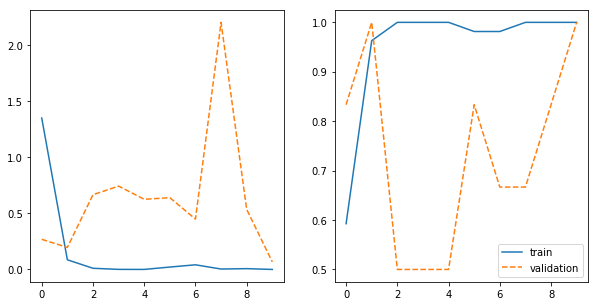

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(history.epoch,history.history['loss'],label='train')
plt.plot(history.epoch,history.history['val_loss'],'--',label='validation')
plt.subplot(122)
plt.plot(history.epoch,history.history['accuracy'],label='train')
plt.plot(history.epoch,history.history['val_accuracy'],'--',label='validation')
plt.legend()
plt.show()

### Step 3: Save Model

In [0]:
!mkdir model
snake_model.save('./model/model.h5')

In [12]:
!sudo pip install tensorflowjs

     |████████████████████████████████| 51kB 2.0MB/s 
     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 17.3MB 7.6MB/s 
     |████████████████████████████████| 109.2MB 210kB/s 
     |████████████████████████████████| 256kB 42.8MB/s 
     |████████████████████████████████| 890kB 36.5MB/s 
     |████████████████████████████████| 655kB 43.5MB/s 
     |████████████████████████████████| 491kB 49.2MB/s 
     |████████████████████████████████| 3.2MB 28.1MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32853 sha256=5093d8214a1edd2d84a9d0a9b72e3eb0eee9824848b35b859619267df921260f
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
  Created wheel for regex: filename=regex-2019.8.19-cp36-cp36m-linux_x86_64.whl size=609226 sha256=fa50466efdc8a5931acccbde845754a9840a122f1a7e8b9317616bac5843f6d5
  Stored in directory: /root/.cache/pip/wheels/90/04/07/b5010fb816721

In [0]:
!mkdir tfjs_model
!tensorflowjs_converter --input_format=keras ./model/model.h5 ./tfjs_model

In [14]:
!zip -r model.zip ./tfjs_model/

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard3of8.bin (deflated 8%)
  adding: tfjs_model/group1-shard5of8.bin (deflated 7%)
  adding: tfjs_model/group1-shard6of8.bin (deflated 7%)
  adding: tfjs_model/group1-shard8of8.bin (deflated 7%)
  adding: tfjs_model/group1-shard4of8.bin (deflated 8%)
  adding: tfjs_model/model.json (deflated 94%)
  adding: tfjs_model/group1-shard7of8.bin (deflated 7%)
  adding: tfjs_model/group1-shard2of8.bin (deflated 8%)
  adding: tfjs_model/group1-shard1of8.bin (deflated 8%)
